In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/steven/Documents/DS340W/Papaer_Code/Crude Oil Prices 1946-Present.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

df_sub = df.loc["2005-01-01":"2018-12-31"]

print(df_sub.head())

            Value
Date             
2005-01-01  46.84
2005-02-01  48.15
2005-03-01  54.19
2005-04-01  52.98
2005-05-01  49.83


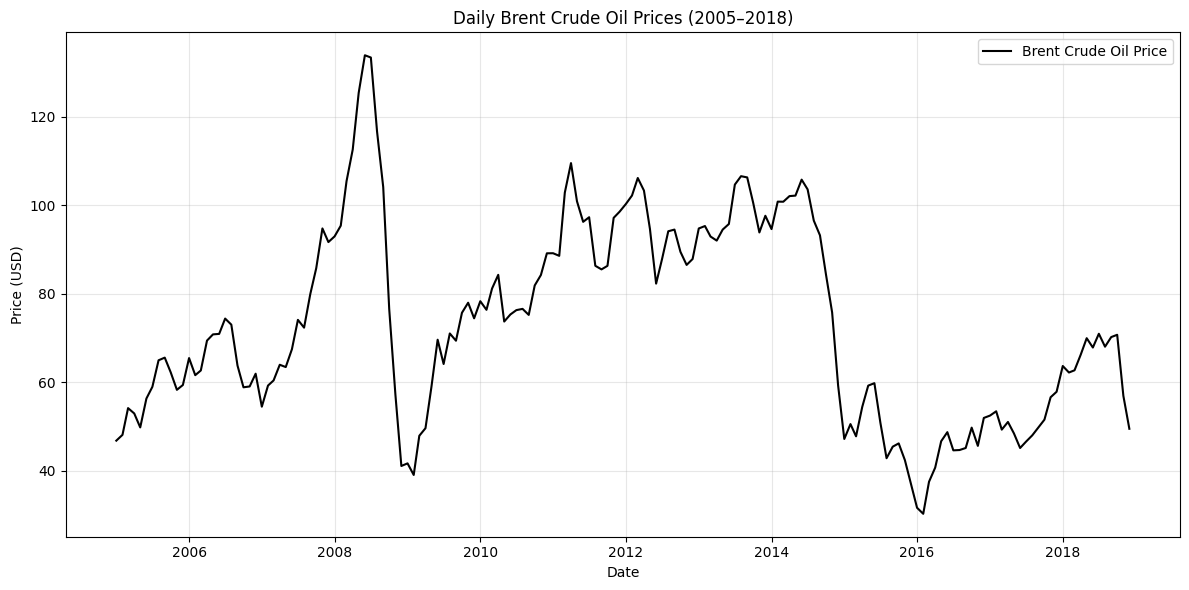

In [2]:
plt.figure(figsize=(12,6))
plt.plot(df_sub.index, df_sub["Value"], label="Brent Crude Oil Price", color="black")
plt.title("Daily Brent Crude Oil Prices (2005–2018)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera

INPUT_CSV = "/Users/steven/Documents/DS340W/Papaer_Code/Crude Oil Prices 1946-Present.csv" 
OUTDIR = "oil_outputs"
START = "2005-01-01"
END   = "2018-12-31"


df = pd.read_csv(INPUT_CSV, parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")

df_sub = df.loc[START:END].copy()

df_sub["Return"] = np.log(df_sub["Value"] / df_sub["Value"].shift(1))
df_sub = df_sub.dropna()

def stats_summary(series):
    s = series.dropna()
    return {
        "Mean (%)": s.mean() * 100,
        "Std. Dev. (%)": s.std() * 100,
        "Skewness": skew(s),
        "Kurtosis": kurtosis(s, fisher=False),
        "Jarque-Bera": jarque_bera(s)[0],
        "JB p-value": jarque_bera(s)[1]
    }

summary = stats_summary(df_sub["Return"])
summary_df = pd.DataFrame([summary], index=["Oil Returns"]).round(4)

print(summary_df)

import os
os.makedirs(OUTDIR, exist_ok=True)
df_sub.to_csv(f"{OUTDIR}/oil_prices_returns_2005_2018.csv")
summary_df.to_csv(f"{OUTDIR}/oil_returns_stats_2005_2018.csv")

print(f"Saved filtered data and stats in folder: {OUTDIR}")

             Mean (%)  Std. Dev. (%)  Skewness  Kurtosis  Jarque-Bera  \
Oil Returns    0.0333         9.0161    -0.891    4.7497      43.3987   

             JB p-value  
Oil Returns         0.0  
Saved filtered data and stats in folder: oil_outputs


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy.stats import jarque_bera, skew, kurtosis

START, END = "2005-01-01", "2018-12-31"
BASEDIR = Path("/mnt/data")
OUTDIR  = Path("connectedness_outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)
TABDIR  = OUTDIR / "tables"; TABDIR.mkdir(exist_ok=True)

def load_price_flexible(path):
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    for col in ["Adj Close", "Close", "Price", "AdjClose", "PX_LAST"]:
        if col in df.columns:
            return df.set_index("Date")[col].astype(float).loc[START:END]
    for c in df.columns:
        if c != "Date" and pd.api.types.is_numeric_dtype(df[c]):
            return df.set_index("Date")[c].astype(float).loc[START:END]
    raise ValueError(f"{path}: no numeric price-like column")

def load_panel_prices(path):
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date").set_index("Date").loc[START:END]
    return df.select_dtypes(include=["number"])

def to_bdays_ffill(s):
    idx = pd.bdate_range(START, END)
    return s.reindex(idx).ffill()

def to_bdays_ffill_panel(df):
    idx = pd.bdate_range(START, END)
    return df.reindex(idx).ffill()

def log_ret(x): 
    return np.log(x/x.shift(1))

def pct(x): 
    return 100*x

def latex_table(df, path, caption=None, label=None, floatfmt="%.4f"):
    with open(path, "w") as f:
        f.write("\\begin{table}[!ht]\n\\centering\n\\begin{tabular}{%s}\n\\toprule\n" % ("l" + "r"*(df.shape[1])))
        f.write(" & ".join([""] + list(df.columns)) + " \\\\\n\\midrule\n")
        for idx, row in df.iterrows():
            vals = [floatfmt % v if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row.values]
            f.write(str(idx) + " & " + " & ".join(vals) + " \\\\\n")
        f.write("\\bottomrule\n\\end{tabular}\n")
        if caption: f.write("\\caption{%s}\n" % caption)
        if label:   f.write("\\label{%s}\n" % label)
        f.write("\\end{table}\n")

print("Setup OK. Outputs ->", OUTDIR.resolve())

Setup OK. Outputs -> /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs


In [5]:
oil  = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/BZ=F_2005_2018.csv").rename("Oil")
vix  = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/^VIX_2005_2018.csv").rename("VIX")
prod = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/XLE_2005_2018.csv").rename("Prod")

exp_prices = load_panel_prices(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/exporter_sectors_2005_2018.csv")
imp_prices = load_panel_prices(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/importer_sectors_2005_2018.csv")

oil_b, vix_b, prod_b = to_bdays_ffill(oil), to_bdays_ffill(vix), to_bdays_ffill(prod)
exp_b = to_bdays_ffill_panel(exp_prices)
imp_b = to_bdays_ffill_panel(imp_prices)

exp_ret = exp_b.pipe(log_ret)
imp_ret = imp_b.pipe(log_ret)

shocks_path = BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/ready_shocks_2005_2018.csv"
if not shocks_path.exists():
    raise FileNotFoundError("Missing ready_shocks_2005_2018.csv. Run the shocks cell we built earlier.")
shocks = pd.read_csv(shocks_path, parse_dates=[0], index_col=0)
bidx = pd.bdate_range(START, END)
shocks = shocks.reindex(bidx).dropna()

exp_ret = exp_ret.reindex(shocks.index).dropna(how="all", axis=1)
imp_ret = imp_ret.reindex(shocks.index).dropna(how="all", axis=1)

min_obs = 250  # daily
exp_ret = exp_ret.loc[:, exp_ret.count() >= min_obs]
imp_ret = imp_ret.loc[:, imp_ret.count() >= min_obs]

print("Exporter sectors:", exp_ret.shape[1], "| Importer sectors:", imp_ret.shape[1], "| Dates:", shocks.index.min(), "->", shocks.index.max())

Exporter sectors: 10 | Importer sectors: 9 | Dates: 2007-07-31 00:00:00 -> 2018-12-31 00:00:00


In [6]:
def desc_table_returns(ret_df):
    out = {}
    for col in ret_df.columns:
        x = ret_df[col].dropna()
        if len(x) == 0: 
            continue
        jb_stat, jb_p = jarque_bera(x.values)
        out[col] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False), 
            "Jarque-Bera": jb_stat
        }
    return pd.DataFrame(out).T

def desc_table_shocks(shk_df):
    out = {}
    for col in ["supply","demand","risk"]:
        x = shk_df[col].dropna()
        jb_stat, jb_p = jarque_bera(x.values)
        out[col.title()+" Shock"] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False),
            "Jarque-Bera": jb_stat
        }
    return pd.DataFrame(out).T

tbl1A = desc_table_returns(exp_ret).reindex(sorted(exp_ret.columns))
tbl1B = desc_table_returns(imp_ret).reindex(sorted(imp_ret.columns))
tbl1C = desc_table_shocks(shocks)

tbl1A.to_csv(TABDIR/"Table1_PanelA_exporters_descriptives.csv")
tbl1B.to_csv(TABDIR/"Table1_PanelB_importers_descriptives.csv")
tbl1C.to_csv(TABDIR/"Table1_PanelC_shocks_descriptives.csv")

latex_table(tbl1A.round(4), TABDIR/"Table1_PanelA_exporters_descriptives.tex",
            caption="Descriptive statistics of exporter sector returns.", label="tab:desc_exporters")
latex_table(tbl1B.round(4), TABDIR/"Table1_PanelB_importers_descriptives.tex",
            caption="Descriptive statistics of importer sector returns.", label="tab:desc_importers")
latex_table(tbl1C.round(4), TABDIR/"Table1_PanelC_shocks_descriptives.tex",
            caption="Descriptive statistics of decomposed shocks.", label="tab:desc_shocks")

print("Saved Table 1 panels to", TABDIR.resolve())
tbl1A.head(3), tbl1B.head(3), tbl1C

Saved Table 1 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


(     Mean (%)  Std. dev. (%)  Skewness   Kurtosis  Jarque-Bera
 IYJ  0.024299       1.352888 -0.395874   9.668114  5576.843974
 IYM  0.013126       1.738458 -0.646430  11.094475  8311.496383
 VAW  0.016866       1.585477 -0.589627  10.499589  7128.961403,
      Mean (%)  Std. dev. (%)  Skewness   Kurtosis   Jarque-Bera
 IYC  0.036910       1.204723 -0.198023  10.095567   6246.393985
 IYH  0.038365       1.059138 -0.329437  10.105582   6298.381320
 IYK  0.027147       0.974946 -0.202165  12.156911  10392.070761,
                   Mean (%)  Std. dev. (%)  Skewness   Kurtosis   Jarque-Bera
 Supply Shock -1.620628e-16       1.746677 -0.002273   8.395044   3599.256437
 Demand Shock  3.725581e-18       1.446618 -0.161879  15.366238  18931.241934
 Risk Shock    3.809128e-03       7.422096  1.352456  11.025487   8874.131798)

In [7]:

def ew_market(ret_df):
    return ret_df.mean(axis=1)

def run_panel_regressions(ret_df, shocks_df, name_prefix):
    mkt = ew_market(ret_df).rename("mkt")
    X = pd.concat([shocks_df[["supply","demand","risk"]], mkt], axis=1).dropna()
    results = []
    for col in sorted(ret_df.columns):
        y = ret_df[col].reindex(X.index).dropna()
        XX = X.reindex(y.index).copy()
        XX = sm.add_constant(XX)
        res = OLS(y, XX, missing="drop").fit()
        row = {
            "Constant": res.params.get("const", np.nan),
            "Supply shock": res.params.get("supply", np.nan),
            "Demand shock": res.params.get("demand", np.nan),
            "Risk shock": res.params.get("risk", np.nan),
            "Aggregate market": res.params.get("mkt", np.nan),
            "R-squared": res.rsquared
        }
        results.append(pd.Series(row, name=col))
    out = pd.DataFrame(results)
    out.to_csv(TABDIR / f"Table2_{name_prefix}_fullperiod.csv", index=True)
    latex_table(out.round(4), TABDIR / f"Table2_{name_prefix}_fullperiod.tex",
                caption=f"Petroleum price shocks and {name_prefix.lower()} sector indices — full period.",
                label=f"tab:t2_{name_prefix.lower()}")
    return out

t2_exporters = run_panel_regressions(exp_ret, shocks, "Exporters")
t2_importers = run_panel_regressions(imp_ret, shocks, "Importers")

print("Saved Table 2 panels to", TABDIR.resolve())
t2_exporters.head(3), t2_importers.head(3)

Saved Table 2 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


(     Constant  Supply shock  Demand shock  Risk shock  Aggregate market  \
 IYJ  0.000150     -0.018993     -0.130298   -0.001269          0.881153   
 IYM  0.000025      0.031568      0.088046   -0.002402          1.006533   
 VAW  0.000067      0.006381      0.013967   -0.001035          0.965086   
 
      R-squared  
 IYJ   0.924318  
 IYM   0.918172  
 VAW   0.935044  ,
      Constant  Supply shock  Demand shock  Risk shock  Aggregate market  \
 IYC -0.000027      0.000159     -0.029411    0.003457          1.161316   
 IYH  0.000072     -0.000930     -0.026543   -0.006133          0.913891   
 IYK -0.000037     -0.001448      0.007309    0.001554          0.903549   
 
      R-squared  
 IYC   0.899214  
 IYH   0.799371  
 IYK   0.872008  )

In [8]:
def run_subperiods(ret_df, shocks_df, label):
    results = {}
    for i, (start, end) in enumerate(SUBS, start=1):
        sub_ret = subset(ret_df, start, end)
        sub_shocks = subset(shocks_df, start, end)

        results[f"{label}_Period{i}"] = {
            "ret_start": sub_ret.index.min() if not sub_ret.empty else None,
            "ret_end":   sub_ret.index.max() if not sub_ret.empty else None,
            "ret_len":   len(sub_ret),
            "shock_start": sub_shocks.index.min() if not sub_shocks.empty else None,
            "shock_end":   sub_shocks.index.max() if not sub_shocks.empty else None,
            "shock_len":   len(sub_shocks),
        }

    return results

In [9]:
SUBS = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2013-12-31"),
    ("2014-01-01", "2018-12-31"),
]

def subset(df, start, end):
    return df.loc[start:end]

print("exp_ret index head/tail:", exp_ret.index.min(), exp_ret.index.max(), "len:", len(exp_ret))
print("imp_ret index head/tail:", imp_ret.index.min(), imp_ret.index.max(), "len:", len(imp_ret))
print("shocks  index head/tail:", shocks.index.min(),  shocks.index.max(),  "len:", len(shocks))


t3_exporters = run_subperiods(exp_ret, shocks, "Exporters")  
t4_importers = run_subperiods(imp_ret, shocks, "Importers")  
"Done"


exp_ret index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980
imp_ret index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980
shocks  index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980


'Done'

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def gfevd_np(res, H=10):
    """
    res: statsmodels.tsa.vector_ar.var_model.VARResults
    H: forecast horizon
    Returns: Theta (k x k) FEVD matrix (rows sum to 1)
    """
    Phi = res.ma_rep(maxn=H)
    Sigma = np.asarray(res.sigma_u, dtype=float)
    k = Sigma.shape[0]

    Theta = np.zeros((k, k), dtype=float)
    denom = np.zeros(k, dtype=float)

    for i in range(k):
        s = 0.0
        for h in range(H + 1):
            phi = Phi[h] 
            s += phi[i, :] @ Sigma @ phi[i, :].T
        denom[i] = s

    for i in range(k):
        for j in range(k):
            num = 0.0
            for h in range(H + 1):
                phi = Phi[h]
                num += (phi[i, :] @ Sigma[:, j]) ** 2 / Sigma[j, j]
            Theta[i, j] = num / denom[i] if denom[i] > 0 else np.nan

    row_sums = Theta.sum(axis=1, keepdims=True)
    Theta = Theta / row_sums
    return Theta  

def dy_table(system_df, lags=2, H=10, row_names=None):
    """
    system_df: DataFrame of aligned returns/shocks (T x k)
    lags: VAR lags
    H: FEVD horizon
    row_names: optional list of variable names for the output table
    Returns: (FEVD dataframe in %, Total Connectedness in %)
    """
    clean = system_df.dropna().astype(float)
    X = clean.values  

    model = VAR(X)
    res = model.fit(lags)

    Theta = gfevd_np(res, H=H)  

    Theta_off = Theta.copy()
    np.fill_diagonal(Theta_off, 0.0)
    TC = Theta_off.sum() / Theta.shape[0]  
    TC_pct = float(TC * 100.0)

    cols = row_names if row_names is not None else list(system_df.columns)
    fevd_df = pd.DataFrame(Theta * 100.0, index=cols, columns=cols)
    return fevd_df, TC_pct

In [11]:
import pandas as pd

sys_exp_o = pd.concat([exp_ret, shocks], axis=1).dropna()

sys_imp_o = pd.concat([imp_ret, shocks], axis=1).dropna()

dy_exp, tc_exp = dy_table(sys_exp_o, lags=2, H=10, row_names=list(sys_exp_o.columns))
dy_imp, tc_imp = dy_table(sys_imp_o, lags=2, H=10, row_names=list(sys_imp_o.columns))

print(f"Exporters TC = {tc_exp:.2f}%")
print(f"Importers TC = {tc_imp:.2f}%")

Exporters TC = 80.12%
Importers TC = 74.27%


In [12]:
print("sys_exp_o shape:", sys_exp_o.dropna().shape, "columns:", list(sys_exp_o.columns))
print("sys_imp_o shape:", sys_imp_o.dropna().shape, "columns:", list(sys_imp_o.columns))

sys_exp_o shape: (2980, 13) columns: ['XLE', 'XLB', 'XLI', 'XLF', 'XME', 'VAW', 'VIS', 'VFH', 'IYM', 'IYJ', 'supply', 'demand', 'risk']
sys_imp_o shape: (2980, 12) columns: ['XLK', 'XLY', 'XLP', 'XLV', 'XLU', 'IYW', 'IYC', 'IYK', 'IYH', 'supply', 'demand', 'risk']


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


def rolling_tc(system_df, lags=2, H=10, window=200):
    """
    Rolling total connectedness (%), Diebold–Yilmaz style.
    system_df: DataFrame (returns + shocks), aligned and numeric
    lags: VAR lags
    H: FEVD horizon
    window: rolling window length (business days)
    """
    clean = system_df.dropna().astype(float)
    vals, idxs = [], []
    for t in range(window, len(clean)):
        sub = clean.iloc[t-window:t]
        try:
            res = VAR(sub.values).fit(lags)
            Theta = gfevd_np(res, H=H)  
            Theta_off = Theta.copy()
            np.fill_diagonal(Theta_off, 0.0)
            tc = Theta_off.sum() / Theta.shape[0] * 100.0
        except Exception:
            tc = np.nan
        vals.append(tc); idxs.append(clean.index[t])
    s = pd.Series(vals, index=idxs).dropna()
    return s

def sensitivity_band(system_df, lags_list=None, H_list=None, window=200):
    """
    Build a (lower, median, upper) band across a set of lags or H values.
    Provide either lags_list or H_list (not both).
    Returns: DataFrame with columns ['lower','median','upper'] indexed by date.
    """
    assert (lags_list is None) ^ (H_list is None), "Pass lags_list OR H_list"
    series = []
    labels = []
    if lags_list is not None:
        for L in lags_list:
            s = rolling_tc(system_df, lags=L, H=10, window=window)
            series.append(s); labels.append(f"L={L}")
    else:
        for h in H_list:
            s = rolling_tc(system_df, lags=2, H=h, window=window)
            series.append(s); labels.append(f"H={h}")

    M = pd.concat(series, axis=1)
    M.columns = labels
    band = pd.DataFrame({
        "lower": M.min(axis=1),
        "median": M.median(axis=1),
        "upper": M.max(axis=1),
    }, index=M.index)
    return band, M  

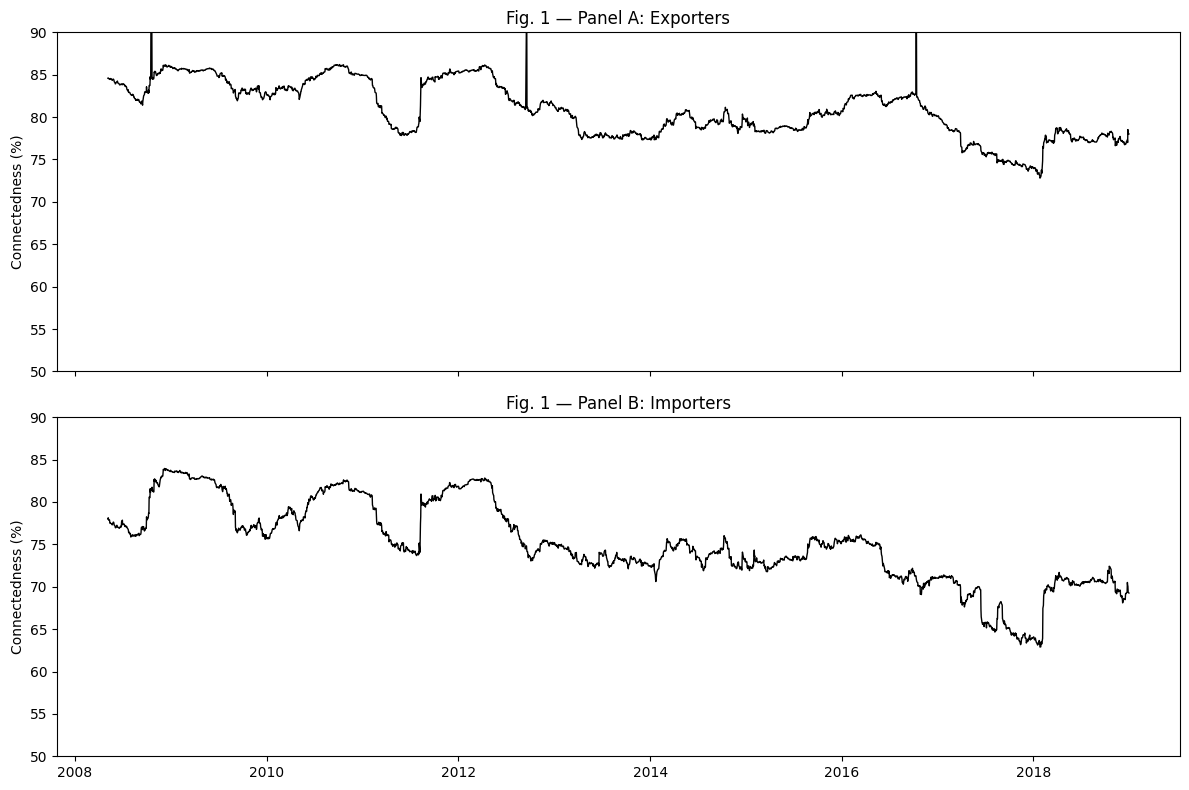

Saved: connectedness_outputs/Fig1_timevarying_connectedness.png


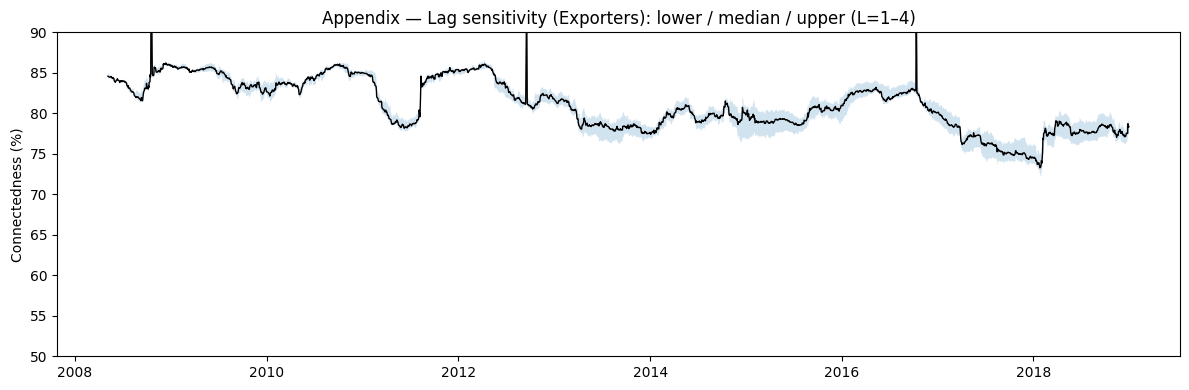

Saved: connectedness_outputs/Appendix_LagBand_Exporters.png


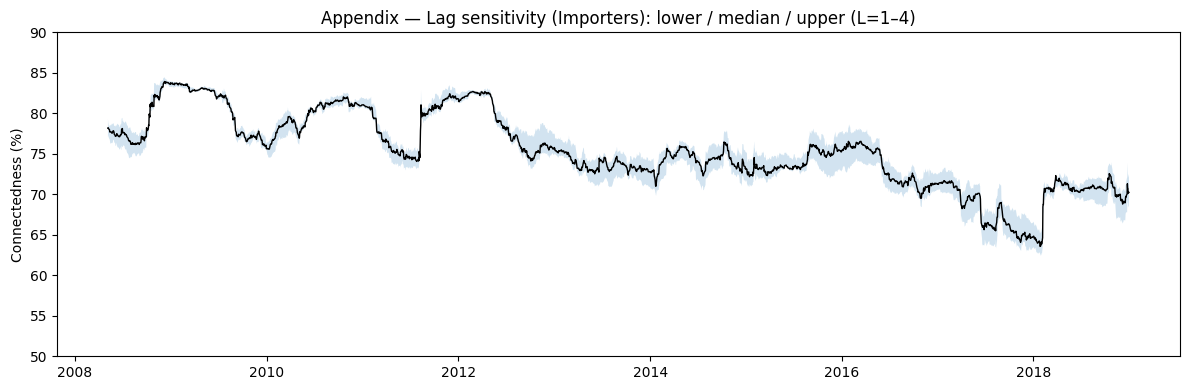

Saved: connectedness_outputs/Appendix_LagBand_Importers.png


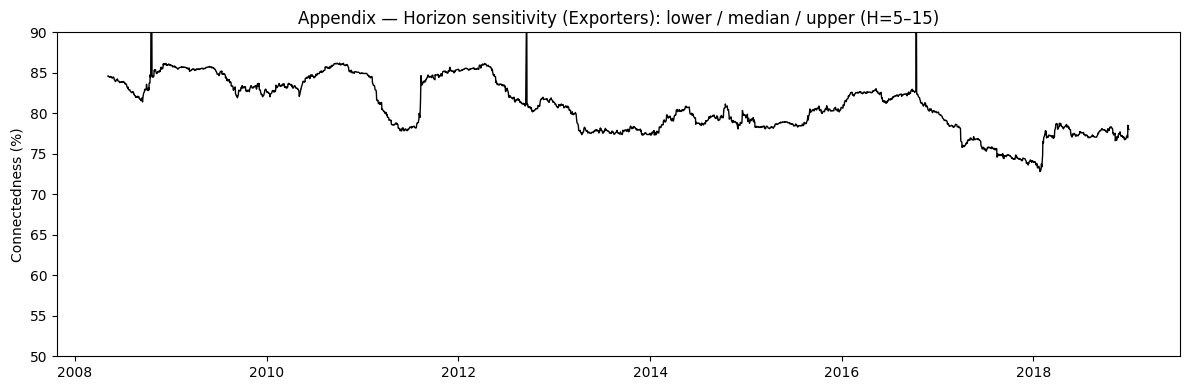

Saved: connectedness_outputs/Appendix_HBand_Exporters.png


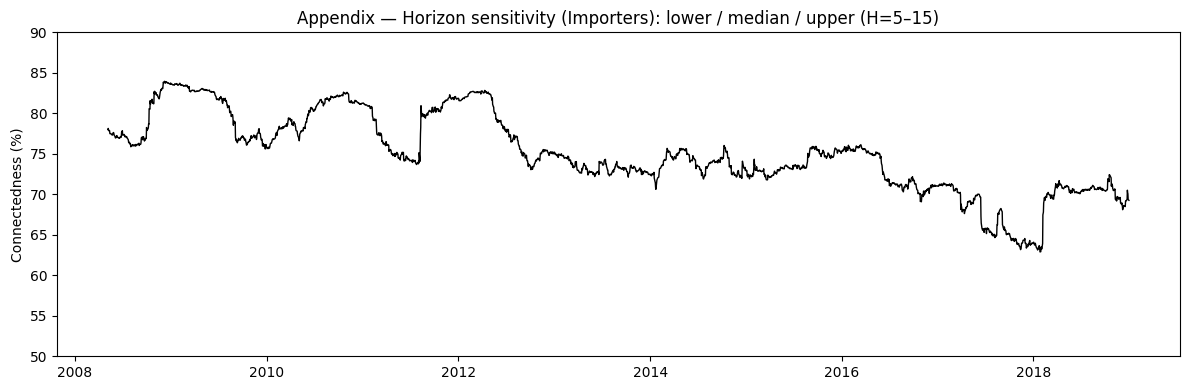

Saved: connectedness_outputs/Appendix_HBand_Importers.png


In [14]:

for nm in ["sys_exp_o", "sys_imp_o"]:
    if nm not in globals():
        raise RuntimeError(f"{nm} is missing. Build it like before (returns+shocks in the paper's order).")

tc_exp = rolling_tc(sys_exp_o, lags=2, H=10, window=200)
tc_imp = rolling_tc(sys_imp_o, lags=2, H=10, window=200)

tc_exp.to_csv(OUTDIR/"Fig1_TC_exporters_series.csv")
tc_imp.to_csv(OUTDIR/"Fig1_TC_importers_series.csv")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(tc_exp.index, tc_exp.values, color="black", linewidth=1.0)
axes[0].set_ylim(50, 90)
axes[0].set_ylabel("Connectedness (%)")
axes[0].set_title("Fig. 1 — Panel A: Exporters")

axes[1].plot(tc_imp.index, tc_imp.values, color="black", linewidth=1.0)
axes[1].set_ylim(50, 90)
axes[1].set_ylabel("Connectedness (%)")
axes[1].set_title("Fig. 1 — Panel B: Importers")

f1 = OUTDIR/"Fig1_timevarying_connectedness.png"
plt.tight_layout(); plt.savefig(f1, dpi=300, bbox_inches="tight"); plt.show()
print("Saved:", f1)

lag_set = [1, 2, 3, 4]
band_exp_lag, grid_exp_lag = sensitivity_band(sys_exp_o, lags_list=lag_set, window=200)
band_imp_lag, grid_imp_lag = sensitivity_band(sys_imp_o, lags_list=lag_set, window=200)

grid_exp_lag.to_csv(OUTDIR/"Sensitivity_exporters_lags_1to4.csv")
grid_imp_lag.to_csv(OUTDIR/"Sensitivity_importers_lags_1to4.csv")

def plot_band(band, title, ylims=(50,90), fname="out.png"):
    plt.figure(figsize=(12,4))
    plt.fill_between(band.index, band["lower"], band["upper"], alpha=0.2)
    plt.plot(band.index, band["median"], color="black", linewidth=1.0)
    plt.ylim(*ylims)
    plt.ylabel("Connectedness (%)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fname)

plot_band(band_exp_lag, "Appendix — Lag sensitivity (Exporters): lower / median / upper (L=1–4)",
          ylims=(50,90), fname=OUTDIR/"Appendix_LagBand_Exporters.png")
plot_band(band_imp_lag, "Appendix — Lag sensitivity (Importers): lower / median / upper (L=1–4)",
          ylims=(50,90), fname=OUTDIR/"Appendix_LagBand_Importers.png")

H_set = list(range(5, 16))  
band_exp_H, grid_exp_H = sensitivity_band(sys_exp_o, H_list=H_set, window=200)
band_imp_H, grid_imp_H = sensitivity_band(sys_imp_o, H_list=H_set, window=200)

grid_exp_H.to_csv(OUTDIR/"Sensitivity_exporters_H_5to15.csv")
grid_imp_H.to_csv(OUTDIR/"Sensitivity_importers_H_5to15.csv")

plot_band(band_exp_H, "Appendix — Horizon sensitivity (Exporters): lower / median / upper (H=5–15)",
          ylims=(50,90), fname=OUTDIR/"Appendix_HBand_Exporters.png")
plot_band(band_imp_H, "Appendix — Horizon sensitivity (Importers): lower / median / upper (H=5–15)",
          ylims=(50,90), fname=OUTDIR/"Appendix_HBand_Importers.png")

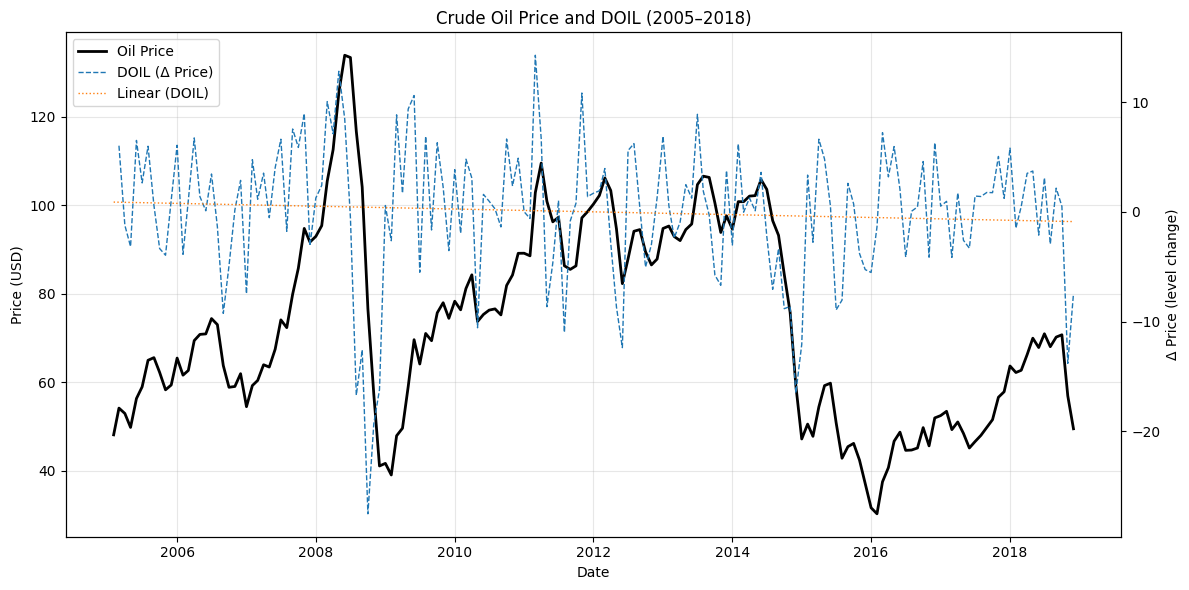

Saved figure to: oil_outputs/figure_crude_price_doil_2005_2018.png


<Figure size 640x480 with 0 Axes>

In [ ]:
doil = df_sub["Value"].diff()

t = (df_sub.index - df_sub.index[0]).days.values
mask = ~doil.isna()
slope, intercept = np.polyfit(t[mask], doil[mask].values, 1)
doil_trend = pd.Series(slope * t + intercept, index=df_sub.index)

fig, ax1 = plt.subplots(figsize=(12, 6))
line1, = ax1.plot(df_sub.index, df_sub["Value"], label="Oil Price", color="black", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
line2, = ax2.plot(df_sub.index, doil, label="DOIL (Δ Price)", linestyle="--", linewidth=1)
line3, = ax2.plot(df_sub.index, doil_trend, label="Linear (DOIL)", linestyle=":", linewidth=1)
ax2.set_ylabel("Δ Price (level change)")

lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Crude Oil Price and DOIL (2005–2018)")
plt.tight_layout()
plt.show()

OUTDIR = Path("oil_outputs"); OUTDIR.mkdir(exist_ok=True, parents=True)
fig_path = OUTDIR / "figure_crude_price_doil_2005_2018.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
doil.to_csv(OUTDIR / "doil_series_2005_2018.csv", header=["DOIL"])
print(f"Saved figure to: {fig_path}")